# Twitter Sentiment Analysis Pipeline #1
*Refer to `notebooks/README.md` for an explanation of the various pipelines*

## Import dependencies

In [1]:
# System
import re
import multiprocessing
from collections import defaultdict
from datetime import datetime

# Data manipulation
import pandas as pd
import numpy as np
from joblib import dump, load

# Graphing/Visualizing
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display

In [2]:
# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [3]:
# NLP
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Prep nltk library
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
## For JupyterThemes ##

# Set plot style
# from jupyterthemes import jtplot
# jtplot.style(theme='onedork')

In [5]:
URL_AND_PUNCT_PATTERN = r'https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*'
CURRENCY_PATTERN = r'\$[a-zA-Z0-9]*'
NON_ALPHA_NUM_PATTERN = r'[^a-zA-Z\']'
MENTIONS_PATTERN = r'\@[a-zA-Z0-9]*'
STOP_WORDS = stopwords.words("english")

def extract(data_path, col_rename_map, target_words):

    # Import data
    raw_tweets_df = pd.read_csv(data_path)
    
    # Rename columns
    tweets_df = raw_tweets_df[list(col_rename_map.keys())].rename(columns=col_rename_map)

    # Drop duplicate tweets
    tweets_df = tweets_df.drop_duplicates(subset='tweet', keep='first')

    # Initialize Lemmatizer
    lemma = WordNetLemmatizer()

    def cleanTweet(tweet):
        tweet = tweet.lower()
        tweet = re.sub(URL_AND_PUNCT_PATTERN, ' ', tweet)
        tweet = re.sub(CURRENCY_PATTERN, ' ', tweet)
        tweet = re.sub(MENTIONS_PATTERN, ' ', tweet)
        tweet = re.sub(NON_ALPHA_NUM_PATTERN, ' ', tweet)
        tweet = ' '.join([w for w in tweet.split() if len(w) > 1])
        
        trimmed_lemma_words = [lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(tweet) 
                                    if x not in STOP_WORDS]
        clean_tweet = ' '.join(trimmed_lemma_words)
        
        return [lemma.lemmatize(x, nltk.corpus.reader.wordnet.VERB) 
                    for x in nltk.wordpunct_tokenize(clean_tweet) if x not in STOP_WORDS]

    def cleanHashtags(hashtags):
        if hashtags:
            hashtags = hashtags.lower()
            hashtags = re.sub(CURRENCY_PATTERN, ' ', hashtags)
            hashtags = re.sub(NON_ALPHA_NUM_PATTERN, ' ', hashtags)
            hashtags = hashtags.strip() 
        return hashtags
    
    
    # Clean tweets
    tweets_df['clean_tweet_words'] = tweets_df['tweet'].apply(lambda x: cleanTweet(x))
    tweets_df['clean_tweet'] = tweets_df['clean_tweet_words'].apply(lambda x:' '.join(x))

    # Clean hashtags
    tweets_df["hashtags"] = tweets_df["hashtags"].astype(str)
    tweets_df["hashtags"] = tweets_df["hashtags"].apply(lambda x: cleanHashtags(x))

    # Convert date to datetime and extract month/year
    tweets_df['date'] = pd.to_datetime(tweets_df['date'])
    tweets_df['month'] = tweets_df['date'].dt.month
    tweets_df['year'] = tweets_df['date'].dt.year

    # Remove all tweets which do not have the provided target words
    keywords_str = '|'.join(target_words)
    target_tweets_df = tweets_df.copy()
    target_tweets_df = target_tweets_df[target_tweets_df["clean_tweet"].str.contains(keywords_str)]

    return target_tweets_df, tweets_df

In [6]:
SENTIMENT_THRESHOLD = 0.15
INIT_WORD_VEC_ALPHA = 0.03
MIN_WORD_VEC_ALPHA = 0.007
WORD_VEC_SIZE = 300
WORD_VEC_SAMPLE = 1e-5
MAX_PRED_DISTANCE = 5
MIN_WORD_FREQ = 4
NEGATIVE_SAMPLING_VALUE = 20
TOP_N_TERMS = 30

def transform(filtered_df, cumulative_df, load_word_vec='', save_word_vec='', 
                load_embeddings='', save_embeddings=''):
    
    # Preseve original df
    transform_tweets_df = filtered_df.copy()
    
    if load_word_vec:
        # Load existing vectors if path provided
        word_vectors = Word2Vec.load(load_word_vec).wv

    else:
        # Restructure the `clean_text` column
        row_sentences = [row for row in cumulative_df["clean_tweet_words"]]

        # Detect common phrases (bigrams) from a list of sentences
        phrases = Phrases(row_sentences, min_count=1, progress_per=50000)
        bigram = Phraser(phrases)
        sentences = bigram[row_sentences]
        
        # Initialize vector model
        word_vec_model = Word2Vec(vector_size=WORD_VEC_SIZE, window=MAX_PRED_DISTANCE, 
                                    min_count=MIN_WORD_FREQ, workers=multiprocessing.cpu_count()-1,
                                    negative=NEGATIVE_SAMPLING_VALUE, sample=WORD_VEC_SAMPLE, 
                                    alpha=INIT_WORD_VEC_ALPHA, min_alpha=MIN_WORD_VEC_ALPHA,  
                                    seed= 42)

        # Establish dataset for the vector model
        word_vec_model.build_vocab(sentences, progress_per=50000)

        # Train the model
        word_vec_model.train(sentences, 
                    total_examples=word_vec_model.corpus_count, 
                    epochs=30, 
                    report_delay=1)
        
        if save_word_vec:
            # Store current word vector model
            word_vec_model.save(save_word_vec)

        word_vectors = word_vec_model.wv
    
    # Build KMeans model to cluster words into positive, negative, and neutral clusters
    cluster_model = KMeans(n_clusters=3, 
               max_iter=1000, 
               random_state=42, 
               n_init=50).fit(X=word_vectors.vectors.astype('double'))
                        

    ## Need user input to determine each cluster's sentiment ##
    print(f'** Top {TOP_N_TERMS} Similar Word Vectors By Cluster**\n')
    cluster_values = np.array(list(zip(
        word_vectors.similar_by_vector(cluster_model.cluster_centers_[0], 
                                                            topn=TOP_N_TERMS, 
                                                            restrict_vocab=None),
        word_vectors.similar_by_vector(cluster_model.cluster_centers_[1], 
                                                            topn=TOP_N_TERMS, 
                                                            restrict_vocab=None),
        word_vectors.similar_by_vector(cluster_model.cluster_centers_[2], 
                                                            topn=TOP_N_TERMS, 
                                                            restrict_vocab=None))))
    
    print('Sentiment of positive ("slava", "slavaukraine") and negative ("war")')
    print('------------')
    manual_similar = word_vectors.most_similar(positive=['slava', 'slavaukraine'], 
                                    negative=['war'], restrict_vocab=False)
    display(pd.DataFrame(manual_similar, columns=['term', 'similarity']))
    
    # Collect terms spanning multiple clusters for deciphering
    term_freq, counts = np.unique([x[0] for x in np.vstack(cluster_values)], 
                                    axis=0, return_counts=True)
    unique_terms = term_freq[counts == 1]

    # Separate unique from duplicate terms
    uniq_cluster_vals = defaultdict(lambda : np.full(len(cluster_values), np.nan, dtype=object))
    shared_cluster_vals = defaultdict(lambda : [0]*3)
    for iy, ix in np.ndindex(cluster_values.shape[:2]):
        tmp = cluster_values[iy, ix]
        if tmp[0] in unique_terms:
            uniq_cluster_vals[ix][iy] = tuple(tmp)
        else:
            shared_cluster_vals[tmp[0]][ix] = tmp[1]

    max_uniq_in_cluster = max([len([x for x in l if not pd.isnull(x)]) for l in uniq_cluster_vals.values()])
    formatted_unique = np.array([np.pad(vals[~pd.isnull(vals)], 
                                    (0,max_uniq_in_cluster-np.count_nonzero(~pd.isnull(vals))), constant_values=None) 
                                    for vals in uniq_cluster_vals.values()], dtype=object).T

    
    print('Unique Terms from Clusters')
    unique_terms_df = pd.DataFrame([[x[0] if x else '' for x in y] for y in formatted_unique], columns=['Cluster 0', 'Cluster 1', 'Cluster 2'])
    display(unique_terms_df)
    # print('Cluster 0\t\t\tCluster 1\t\t\tCluster 2')
    # for i, r in enumerate(formatted_unique):
    #     c1 = r[0] if r[0] else ('xxxx', '----')
    #     c2 = r[1] if r[1] else ('xxxx', '----')
    #     c3 = r[2] if r[2] else ('xxxx', '----')
        
    #     print(f'{i}: {c1[0]} - ({str(c1[1])[:7]})\t\t{c2[0]} - ({str(c2[1])[:7]})\t\t{c3[0]} - ({str(c3[1])[:7]})')

    print('\nDuplicate Terms from Clusters')
    # print('\t\tCluster 0\t\t\tCluster 1\t\t\tCluster 2')
    # for key, vals in shared_cluster_vals.items():
    #     print(f'{key}:\t\t{vals[0]}\t\t{vals[1]}\t\t{vals[2]}')
    duplicate_terms_df = pd.DataFrame.from_dict(shared_cluster_vals, orient='index', columns=['Cluster 0', 'Cluster 1', 'Cluster 2'])
    display(duplicate_terms_df)

    # Mapping for sentiment encodings
    sentiment_mapping = { 0: "neutral", 1: "positive", -1: "negative" }

    print('\nLabel each cluster: -1 = negative, 0 = neutral, 1 = positive ("q" to exit)')
    cluster_sentiment_defs = []
    user_input = ''
    while len(cluster_sentiment_defs) < 3 and user_input != 'q':
        user_input = input(f'Cluster {len(cluster_sentiment_defs)} value:')
        if user_input == 'q':
            print('Aborting...')
            return None, None
        try:
            value = int(user_input)
            if value in cluster_sentiment_defs or value not in range(-1, 2):
                print('Already used this sentiment or not in range (-1, 0, 1)')
                continue
            cluster_sentiment_defs.append(value)
            print(f'Set cluster {len(cluster_sentiment_defs)-1} to {value} - {sentiment_mapping[value]}')
        except ValueError:
            print('Need a number in range (-1, 0, 1). Press q to exit')

    # Assign 1 to positive values, 0 to neutral and -1 for negative values
    # cluster_sentiment_map = defaultdict(lambda : -1, { 2: 1, 0: 0 })
    print(cluster_sentiment_defs)

    if load_embeddings:
        # Load existing embeddings file
        words_df = pd.read_csv(load_embeddings)

    else:
        # Create a DataFrame of words with their embeddings and cluster values
        words_df = pd.DataFrame(word_vectors.index_to_key)
        words_df.columns = ['words']
        words_df['vectors'] = words_df.words.apply(lambda x: word_vectors[f'{x}'])
        words_df['cluster'] = words_df.vectors.apply(lambda x: cluster_model.predict([np.array(x)]))
        words_df.cluster = words_df.cluster.apply(lambda x: x[0])

        
        words_df['cluster_value'] = [cluster_sentiment_defs[i] for i in words_df.cluster]
        # words_df['cluster_value'] = [1 if i==2 else 0 if i==0 else -1 for i in words_df.cluster]

        # Calculate proximity of words in each vector
        calc_vector_nearness = lambda x: 1 / (cluster_model.transform([x.vectors]).min())
        words_df['closeness_score'] = words_df.apply(calc_vector_nearness, axis=1)
        words_df['sentiment_coeff'] = words_df.closeness_score * words_df.cluster_value

        # Map sentiment encodings
        words_df["sentiments"] = words_df["cluster_value"].map(sentiment_mapping)

        if save_embeddings:
            # Store current word embeddings
            words_df.to_csv(save_embeddings)

    # Get the sentiment for the entire tweet
    def getSentiment(row, sentiment_dict):
        total, count = 0, 0
        test = row["clean_tweet_words"]
        for t in test:
            total += int(words_cluster_dict.get(t, 0))
            # if score := words_cluster_dict.get(t):
            #     total += int(score)
            count += 1 
            
        avg = total / count
        return -1 if (avg < -SENTIMENT_THRESHOLD) else 1 if (avg > SENTIMENT_THRESHOLD) else 0


    # Create a dictionary of the word and its cluster value
    words_cluster_dict = dict(zip(words_df.words, words_df.cluster_value))

    # Add sentiment column (integer values)
    transform_tweets_df["sentiment"] = transform_tweets_df.apply(getSentiment,
                                                         args=(words_cluster_dict,),
                                                         axis=1)

    # Map integer sentiment to word value
    transform_tweets_df["sentiments_val"] = transform_tweets_df["sentiment"].map(sentiment_mapping)


    return transform_tweets_df, words_df

In [7]:
TEST_SIZE = 0.2
DFLT_VECTOR_OUT_PATTERN = r'\/[^/]*$'

def model(sent_analyzed_df, load_svc='', save_svc='', load_nb='', save_nb='', 
                load_vectorizer='', save_vectorizer=''):
    
    # Convert each sentiment to df (no need to worry about memory crash, small dataset)
    pos_df = sent_analyzed_df[sent_analyzed_df["sentiments_val"]=="positive"]
    neg_df = sent_analyzed_df[sent_analyzed_df["sentiments_val"]=="negative"]
    neu_df = sent_analyzed_df[sent_analyzed_df["sentiments_val"]=="neutral"]

    # Combine all sentiments in one df
    sentiments_df_list = [pos_df, neg_df, neu_df] 
    agg_sentiment_df = pd.concat(sentiments_df_list)

    # Split the data to training, testing, and validation data 
    train_test_df, _ = train_test_split(agg_sentiment_df, test_size=TEST_SIZE, random_state=10)

    X = train_test_df['clean_tweet']
    y = train_test_df['sentiment']

    # Split the dataset set int0 training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

    # Instantiate TfidfVectorizer 
    if load_vectorizer:
        vectorizer = load(load_vectorizer)
    else:
        vectorizer = TfidfVectorizer(min_df=3,
                                    sublinear_tf=True,
                                    ngram_range=(1,2),
                                    stop_words='english')

    # Fit vectorizer
    X_train_tf = vectorizer.fit_transform(X_train.reset_index()["clean_tweet"]).toarray()
    X_test_tf = vectorizer.transform(X_test.reset_index()["clean_tweet"]).toarray()

    # Store features from the vectors
    feature_names = vectorizer.get_feature_names_out()

    # Create a dict of Sentiment_val: sentiments to use with the confusion matrix
    sentiment_id_df = agg_sentiment_df[['sentiments_val', 'sentiment']].drop_duplicates() \
                                                                        .sort_values('sentiment')
    sentiment_to_id = dict(sentiment_id_df.values)

    ## LinearSVC ##

    if load_svc:
        # Import previous linearSVC model (NOTE: Must use same vectorizer from its fitting)
        linearSVC = load(load_svc)

    else:
        # Instantiate the model
        linearSVC = LinearSVC(random_state=0)

        # Fit the model
        linearSVC.fit(X_train_tf, y_train)

        if save_svc:
            dump(linearSVC, save_svc)

    # Predict
    svc_y_pred = linearSVC.predict(X_test_tf)

    # Build confusion matrix to evaluate the model results
    svc_conf_mat = confusion_matrix(y_test, svc_y_pred, labels=np.unique(svc_y_pred))

    # Get classification report
    svc_classification = classification_report(y_test, svc_y_pred, labels=np.unique(svc_y_pred))

    # Use score method to get accuracy of model
    svc_score = linearSVC.score(X_test_tf, y_test)

    ## MultinomialNB ##

    if load_nb:
        # Import previous multinomialNB model (NOTE: Must use same vectorizer from its fitting)
        multiNB = load(load_nb)

    else:
        # Instantiate the model
        multiNB = MultinomialNB()

        # Fit the model
        multiNB.fit(X_train_tf, y_train)

        if save_nb:
            dump(multiNB, save_nb)

    # Predict
    nb_y_pred = multiNB.predict(X_test_tf)

    # Build confusion matrix to evaluate the model results
    nb_conf_mat = confusion_matrix(y_test, nb_y_pred, labels=np.unique(nb_y_pred))

    # Get classification report
    nb_classification = classification_report(y_test, nb_y_pred, labels=np.unique(nb_y_pred))

    # Use score method to get accuracy of model
    nb_score = multiNB.score(X_test_tf, y_test)

    if save_vectorizer:
        dump(vectorizer, save_vectorizer)

    elif save_svc or save_nb:
        vector_out_match = re.search(DFLT_VECTOR_OUT_PATTERN, save_svc if save_svc else save_nb)
        if not vector_out_match.group():
            print('Error: could not extract default vectorizer output path')
        else:
            dump(vectorizer, re.sub(vector_out_match.group(), '/vectorizer.joblib', 
                    vector_out_match.string))

    return {
        'LinearSVC': {
            'model': linearSVC,
            'conf_mat': svc_conf_mat,
            'classification': svc_classification,
            'score': svc_score,
        },
        'MultinomialNB': {
            'model': multiNB,
            'conf_mat': nb_conf_mat,
            'classification': nb_classification,
            'score': nb_score,
        },
        'features': feature_names,
        'vectorizer': vectorizer,
        'sentiment_id': sentiment_id_df,
        'sentiment_to': sentiment_to_id
    }

In [8]:
def pipeline(data_path, column_mappings, target_words, build_models=False, io_options={}):

    print('Initializing Stage 1: Extracting...')

    target_df, all_tweets_df = extract(data_path=data_path, 
                                col_rename_map=column_mappings,
                                target_words=target_words)

    print('Completed Stage 1.\n\nInitializing Stage 2: Transforming...')

    transform_tweets_df, word_vecs = transform(filtered_df=target_df, 
                        cumulative_df=all_tweets_df,
                        load_word_vec=io_options.get('load_word_vec', ''),
                        save_word_vec=io_options.get('save_word_vec', ''),
                        load_embeddings=io_options.get('load_embedding', ''),
                        save_embeddings=io_options.get('save_embeddings', ''))

    print('Completed Stage 2.')

    model_dict = None
    if build_models and transform_tweets_df is not None:
        print('\n\nInitializing Stage 3: Modeling...')
        model_dict = model(sent_analyzed_df=transform_tweets_df,
                            load_svc=io_options.get('load_svc', ''),
                            save_svc=io_options.get('save_svc', ''),
                            load_nb=io_options.get('load_nb', ''),
                            save_nb=io_options.get('save_nb', ''),
                            load_vectorizer=io_options.get('load_vectorizer', ''),
                            save_vectorizer=io_options.get('save_vectorizer', ''))
        print('Completed Stage 3.')

    return transform_tweets_df, word_vecs, model_dict

In [9]:
data_path = '../data/raw/slava_ukraini_tweets.csv'

curr_timestamp = re.sub(':', '-', datetime.utcnow().isoformat('_', timespec='minutes'))

col_rename_map = {
    'date': 'date',
    'user_name': 'username',
    # 'user_description': 'description',
    # 'user_location': 'location',
    'retweets': 'retweets',
    'text': 'tweet',
    'hashtags': 'hashtags'
}
keywords = ['ukraine', 'russia', 'zelensky']
io_params = {
    'load_word_vec': '',
    'save_word_vec': f'../models/word_vec_{curr_timestamp}.model',
    'load_embeddings': '',
    'save_embeddings': f'../data/embeddings/words_{curr_timestamp}.csv',
    'load_svc': '',
    'save_svc': f'../models/linearSVC_{curr_timestamp}.joblib',
    'load_nb': '',
    'save_nb': f'../models/multinomialNB_{curr_timestamp}.joblib',
    'load_vectorizer': '',
    'save_vectorizer': f'../models/vectorizer_{curr_timestamp}.joblib'
}

sentiment_df, word_vecs, model_dict = pipeline(data_path=data_path,
                                                column_mappings=col_rename_map,
                                                target_words=keywords,
                                                io_options=io_params,
                                                build_models=True)

Initializing Stage 1: Extracting...
Completed Stage 1.

Initializing Stage 2: Transforming...
** Top 30 Similar Word Vectors By Cluster**

Sentiment of positive ("slava", "slavaukraine") and negative ("war")
------------


,term,similarity
0,warrior,0.999318
1,istandwithukriane,0.999310
2,nuclear,0.999306
3,do,0.999303
4,rd,0.999298
5,individual,0.999297
6,pound,0.999297
7,manage,0.999297
8,special,0.999296
9,winnipeg,0.999295


Unique Terms from Clusters


,Cluster 0,Cluster 1,Cluster 2
0,remarkable,manage,god_protect
1,cross,pas,defence
2,send_weapon,fckputin,wife
3,burn_hell,capital,translate
4,answer,,
5,disgust,,
6,god_bless,,
7,outstanding,,
8,gas,,
9,awesome,,



Duplicate Terms from Clusters


,Cluster 0,Cluster 1,Cluster 2
toy,0.9998473525047302,0.9998460412025452,0.9998482465744019
com,0.9998416304588318,0.999829113483429,0.9998407363891602
stick,0.9998340010643005,0.9998293519020081,0.9998338222503662
russian_military,0.9998364448547363,0,0.9998353719711304
gonna,0.9998352527618408,0.9998195767402649,0.9998341202735901
last_day,0.9998341798782349,0.999828577041626,0.9998315572738647
within,0.9998345375061035,0,0.999833881855011
never_forget,0.9998334050178528,0.9998260140419006,0.9998339414596558
conflict,0.9998335242271423,0,0.9998340606689453
russianwarcrimes,0.9998286962509155,0.9998259544372559,0.9998286366462708



Label each cluster: -1 = negative, 0 = neutral, 1 = positive ("q" to exit)
Set cluster 0 to -1 - negative
Set cluster 1 to 0 - neutral
Set cluster 2 to 1 - positive
[-1, 0, 1]
Completed Stage 2.


Initializing Stage 3: Modeling...
Completed Stage 3.


In [10]:
sentiment_df.sentiments_val.value_counts()

negative    11487
neutral       425
positive       57
Name: sentiments_val, dtype: int64

## Visualizations

In [11]:
class GraphicProcessors:
    
    # Display a word cloud with the given text
    def generateWordcloud(text):
        words=' '.join([words for words in text])
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(words)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.show()

    # Shorthand functions for commonly used plots
    graphWordDistribution = lambda word_vecs: GraphicProcessors.graphDistribution(word_vecs, 'sentiments', 'Sentiment Distribution of Words')
    graphTweetDistribution = lambda tweet_df: GraphicProcessors.graphDistribution(tweet_df, 'sentiments_val', 'Sentiment Distribution of Tweets')

    # Make a pie chart from a dataframe's column distribution
    def graphDistribution(df, plot_col, title='', fig_size=(7, 7)):
        fig = plt.gcf()
        fig.set_size_inches(fig_size)
        colors = ["crimson", "steelblue", "mediumseagreen"]

        pie_df = df[plot_col].value_counts().reset_index()

        plt.pie(pie_df[plot_col],
                labels=pie_df["index"],
                radius=2,
                colors=colors,
                autopct="%1.1f%%")

        plt.axis('equal')
        if title:
            plt.title(title, fontsize=20)
        plt.show()
        return pie_df

    # Display a bar chart with the counts of values within a specific column
    def graphKeywordCounts(df, plot_col, count_col, keywords):
        # Inspect keyword sentiment
        pattern = '|'.join(keywords)
        keyword_sent_df = df[(df[plot_col].str.contains(pattern))]
        sns.countplot(x=keyword_sent_df[count_col]);

    # Shorthand functions for commonly used plots
    graphTop10Usernames = lambda tweets_df: GraphicProcessors.graphCounts(tweets_df, 'username', 'sentiments_val', 'Top 10 Highest Tweeting usernames', tweets_df['username'].value_counts().iloc[:10].index)
    graphTop10Hashtags = lambda tweets_df: GraphicProcessors.graphCounts(tweets_df, 'hashtags', 'sentiments_val', 'Top 10 Hashtags', tweets_df['hashtags'].value_counts().iloc[1:10].index, (15,10))

    # Display a more detailed bar chart from `graphKeywordSentiment`
    def graphCounts(df, x_col, hue_col=None, title='', order=None, plt_size=(10,8)):
        fig = plt.subplots(figsize=plt_size)
        if title:
            plt.title(title, fontsize=20)
        chart = sns.countplot(x=x_col, 
                                data=df, 
                                palette="Set2", 
                                hue=hue_col,
                                order=order)

        chart.set_xticklabels(chart.get_xticklabels(),
                                rotation=30, 
                                horizontalalignment='right')

    # Display a confusion matrix generated by a sklearn/tensorflow model
    def graphConfusionmatrix(conf_mat, sentiment_id_df):
        fig, ax = plt.subplots(figsize=(5,5))
        sns.heatmap(conf_mat, 
                    annot=True, 
                    fmt='d',
                    xticklabels=sentiment_id_df.sentiments_val.values, 
                    yticklabels=sentiment_id_df.sentiment.values)

        plt.ylabel('Actual')
        plt.xlabel('Predicted')

    # Graph a bar chart of the top portion of feature coefficients from a model
    def graphCoefficients(model, feature_names, top_features=20, fig_size=(15, 5)):

        coefficients_and_features = sorted(zip(model.coef_[0], feature_names)) 
        features_coef_df = pd.DataFrame(coefficients_and_features)
        features_coef_df.columns = 'coefficient','word'
        features_coef_df.sort_values(by='coefficient')

        num_features = len(feature_names)
        neg_coefficients = model.coef_[-1][:num_features]
        pos_coefficients = model.coef_[1][:num_features]
        top_pos_coefficients = np.argsort(pos_coefficients[pos_coefficients > 0])[-top_features:]
        top_neg_coefficients = np.argsort(pos_coefficients[neg_coefficients < 0])[:top_features]
        top_coefficients = np.hstack([top_neg_coefficients, top_pos_coefficients])
        total_coefficients = np.hstack([neg_coefficients, pos_coefficients])
        
        # create plot
        fig = plt.figure(figsize=fig_size)
        colors = ['red' if c < 0 else 'blue' for c in total_coefficients[top_coefficients]]
        feature_names = np.array(feature_names)

        plt.bar(np.arange(2 * top_features), total_coefficients[top_coefficients], color=colors)
        plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
        title="Positive and Negative Labels"
        plt.title(title)
        plt.show()

### Distributions

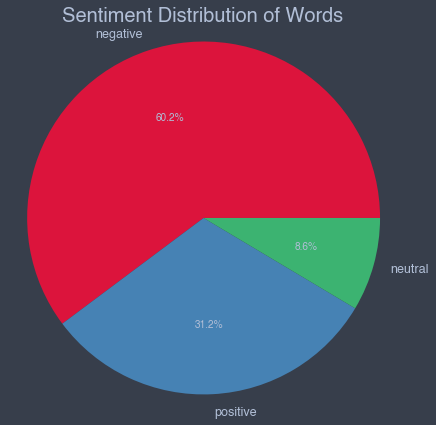

,index,sentiments
0,negative,3104
1,positive,1609
2,neutral,441


In [12]:
GraphicProcessors.graphWordDistribution(word_vecs)

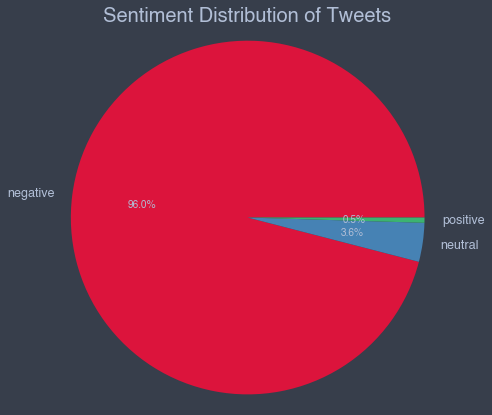

,index,sentiments_val
0,negative,11487
1,neutral,425
2,positive,57


In [13]:
GraphicProcessors.graphTweetDistribution(sentiment_df)

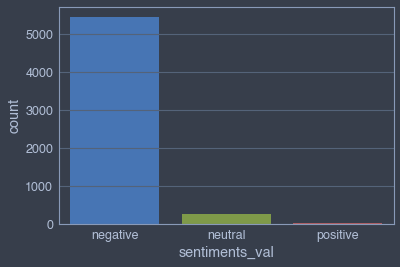

In [14]:
GraphicProcessors.graphKeywordCounts(sentiment_df, 'clean_tweet', 'sentiments_val', ['russia'])

### Counts

/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7457 (\N{LATIN LETTER SMALL CAPITAL W}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7431 (\N{LATIN LETTER SMALL CAPITAL E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7458 (\N{LATIN LETTER SMALL CAPITAL Z}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127987 (\N{WAVING WHITE FLAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.

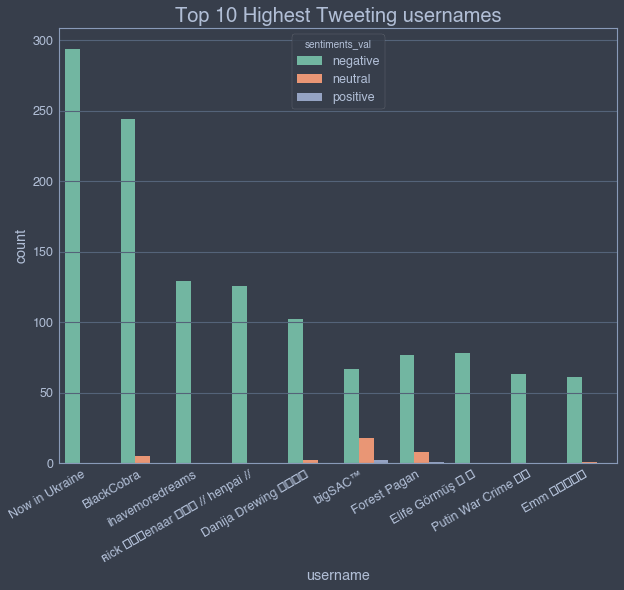

In [15]:
GraphicProcessors.graphTop10Usernames(sentiment_df)

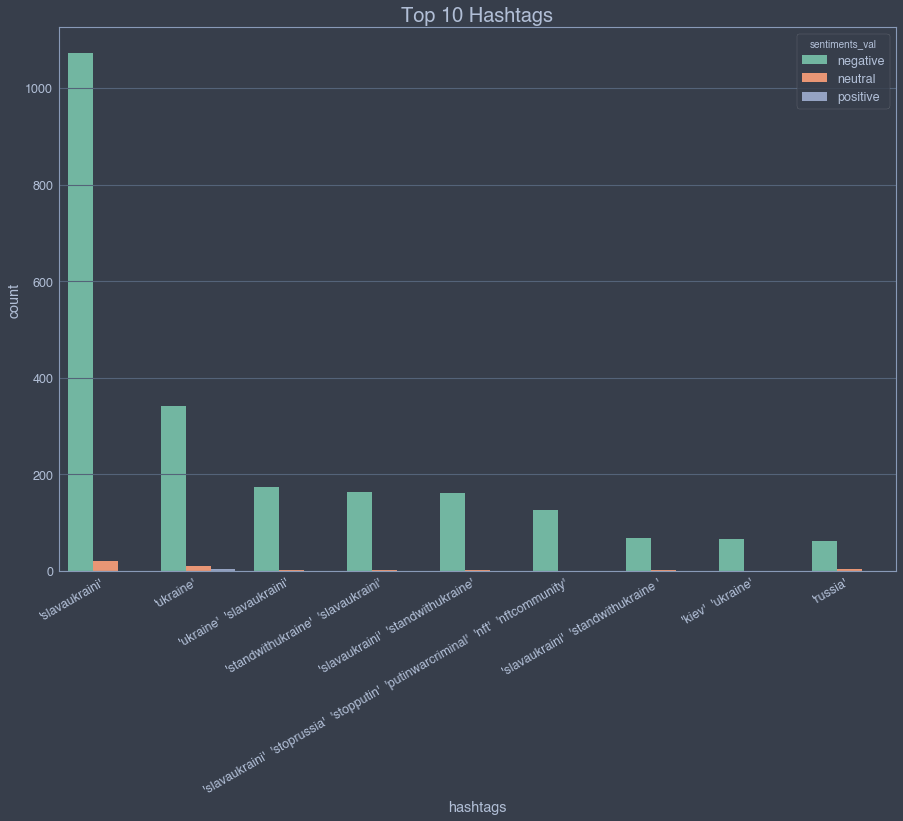

In [16]:
GraphicProcessors.graphTop10Hashtags(sentiment_df)

### Word Clouds

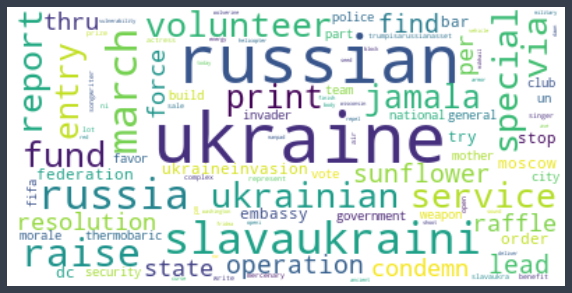

In [17]:
# Cloud for positive sentiment tweets
GraphicProcessors.generateWordcloud(sentiment_df[sentiment_df["sentiment"]==1]["clean_tweet"].values)

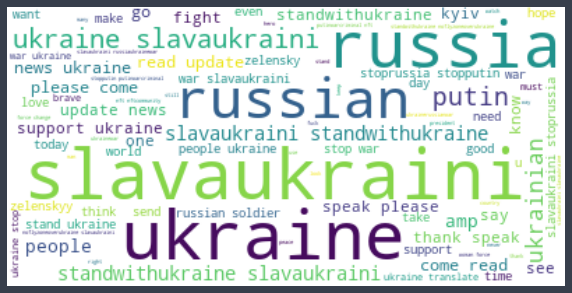

In [18]:
# Cloud for negative sentiment tweets
GraphicProcessors.generateWordcloud(sentiment_df[sentiment_df["sentiment"]==-1]["clean_tweet"].values)

### Confusion Matricies

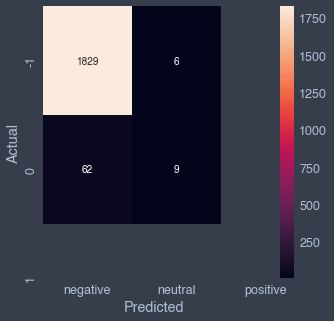

In [19]:
GraphicProcessors.graphConfusionmatrix(model_dict['LinearSVC']['conf_mat'], model_dict['sentiment_id'])

### Feature Coefficients

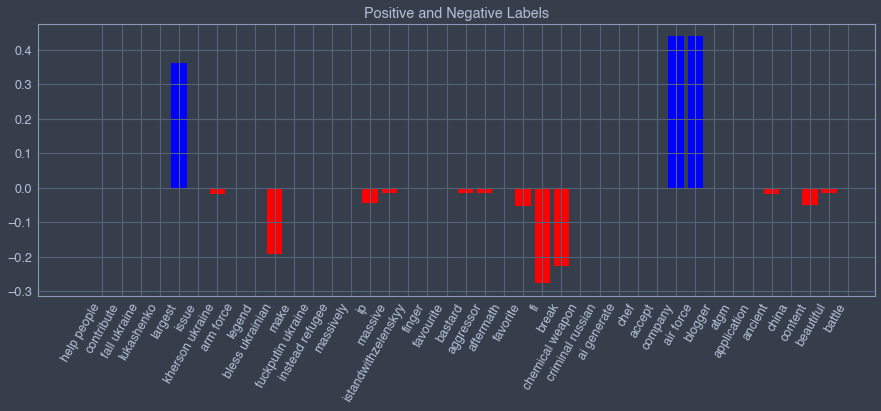

In [20]:
GraphicProcessors.graphCoefficients(model_dict['LinearSVC']['model'], model_dict['features'])